In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from datetime import datetime

# Read the CSV file
def read_sleep_data(file_path):
    df = pd.read_csv(file_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    return df

def find_dense_periods(df, stage, window_size=3600):
    # Create binary array for the specified stage
    stage_binary = (df['sleepStage'] == stage).astype(int)
    
    # Calculate percentage in sliding window
    stage_density = []
    for i in range(len(df) - window_size + 1):
        window = stage_binary[i:i + window_size]
        density = np.mean(window)
        stage_density.append(density)
    
    # Convert to numpy array
    stage_density = np.array(stage_density)
    
    # Find peaks above 66% threshold
    peaks, _ = find_peaks(stage_density, height=0.66, distance=1200)  # 1200s = 20min
    
    # Convert peak indices to timestamps
    dense_periods = []
    for peak in peaks:
        period_start = df['Timestamp'].iloc[peak]
        period_end = df['Timestamp'].iloc[peak + window_size]
        dense_periods.append({
            'start': period_start,
            'end': period_end,
            'center': period_start + pd.Timedelta(seconds=window_size/2)
        })
    
    return dense_periods

def main():
    # Read data
    df = read_sleep_data('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv')
    
    # Find dense periods for NREM (stage=2)
    nrem_periods = find_dense_periods(df, stage=2)
    
    # Find dense periods for Awake (stage=1)
    awake_periods = find_dense_periods(df, stage=1)
    
    # Print results
    print("NREM Dense Periods:")
    for period in nrem_periods:
        print(f"Start: {period['start']}, End: {period['end']}")
    
    print("\nAwake Dense Periods:")
    for period in awake_periods:
        print(f"Start: {period['start']}, End: {period['end']}")

if __name__ == "__main__":
    main()

NREM Dense Periods:
Start: 2024-12-16 19:04:27, End: 2024-12-16 20:04:27
Start: 2024-12-16 19:31:01, End: 2024-12-16 20:31:01
Start: 2024-12-16 20:24:27, End: 2024-12-16 21:24:27
Start: 2024-12-16 20:51:40, End: 2024-12-16 21:51:40
Start: 2024-12-17 04:39:18, End: 2024-12-17 05:39:18
Start: 2024-12-17 05:15:42, End: 2024-12-17 06:15:42
Start: 2024-12-17 05:49:04, End: 2024-12-17 06:49:04
Start: 2024-12-17 10:07:11, End: 2024-12-17 11:07:11
Start: 2024-12-17 12:26:22, End: 2024-12-17 13:26:22
Start: 2024-12-17 14:16:06, End: 2024-12-17 15:16:06
Start: 2024-12-17 14:46:29, End: 2024-12-17 15:46:29
Start: 2024-12-17 16:19:24, End: 2024-12-17 17:19:24
Start: 2024-12-17 18:09:05, End: 2024-12-17 19:09:05
Start: 2024-12-18 02:53:06, End: 2024-12-18 03:53:06
Start: 2024-12-18 03:18:48, End: 2024-12-18 04:18:48
Start: 2024-12-18 05:18:34, End: 2024-12-18 06:18:34
Start: 2024-12-18 10:08:36, End: 2024-12-18 11:08:36
Start: 2024-12-18 11:37:02, End: 2024-12-18 12:37:02
Start: 2024-12-18 12:01:20

/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_13823/1556896962.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_13823/1556896962.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='Stage', y='Exponent',


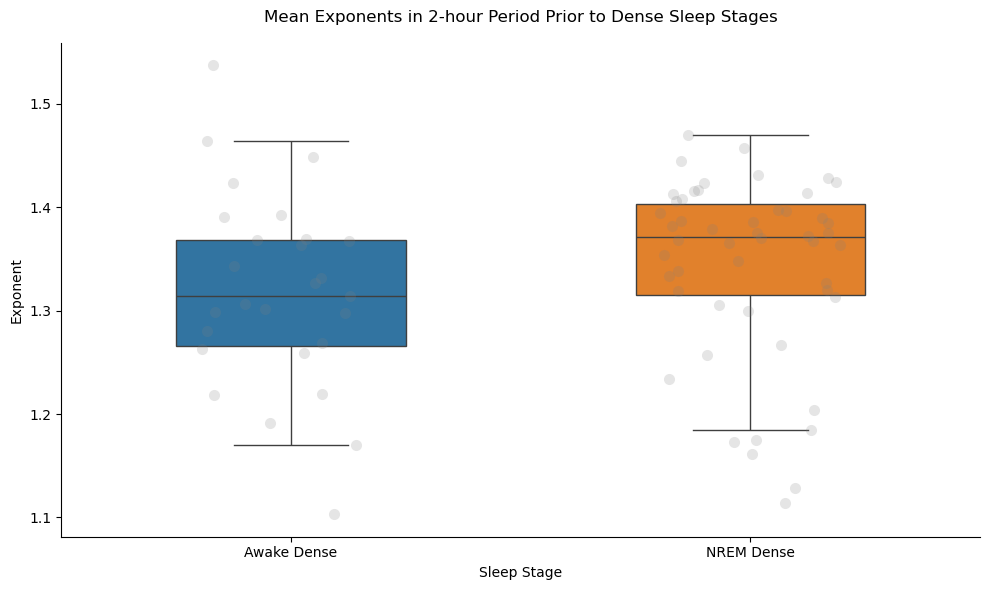

In [12]:
import pandas as pd
import numpy as np
import pickle
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Load data
sleep_df = pd.read_csv('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv')
sleep_df['Timestamp'] = pd.to_datetime(sleep_df['Timestamp'])

with open('/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl', 'rb') as f:
    fg_models = pickle.load(f)

# Create exponent DataFrame
exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
avg_exps = (exps_eeg1 + exps_eeg2) / 2

exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0], 
                         periods=len(avg_exps), 
                         freq='10S')
exp_df = pd.DataFrame({'Timestamp': exp_times, 'exponent': avg_exps})

# Find dense periods
def find_dense_periods(stage, window_size=3600):
    stage_binary = (sleep_df['sleepStage'] == stage).astype(int)
    stage_density = []
    
    for i in range(len(sleep_df) - window_size + 1):
        density = np.mean(stage_binary[i:i + window_size])
        stage_density.append(density)
    
    peaks, _ = find_peaks(stage_density, height=0.66, distance=1200)
    return [sleep_df['Timestamp'].iloc[peak] for peak in peaks]

# Calculate mean exponent for 2h prior to each dense period
def get_prior_mean_exponents(period_starts):
    prior_means = []
    for start in period_starts:
        window_start = start - timedelta(hours=2)
        mask = (exp_df['Timestamp'] >= window_start) & (exp_df['Timestamp'] < start)
        prior_means.append(exp_df.loc[mask, 'exponent'].mean())
    return prior_means

# Get periods and their prior mean exponents
nrem_periods = find_dense_periods(stage=2)
awake_periods = find_dense_periods(stage=1)

nrem_exps = get_prior_mean_exponents(nrem_periods)
awake_exps = get_prior_mean_exponents(awake_periods)

# Create figure and axis correctly
fig, ax = plt.subplots(figsize=(10, 6))

# Create DataFrame with reordered categories
data = {
    'Exponent': awake_exps + nrem_exps,  
    'Stage': ['Awake Dense']*len(awake_exps) + ['NREM Dense']*len(nrem_exps)
}
df_plot = pd.DataFrame(data)

# Create boxplot without outliers
sns.boxplot(data=df_plot, x='Stage', y='Exponent', 
            showfliers=False, 
            color='white',
            width=0.5,
            palette='tab10',
            ax=ax)


# Add individual points with jitter
sns.stripplot(data=df_plot, x='Stage', y='Exponent',
              color='grey', 
              alpha=0.2,
              jitter=0.2,
              size=8,
              ax=ax)

# Customize plot
ax.set_title('Mean Exponents in 2-hour Period Prior to Dense Sleep Stages', pad=15)
ax.set_xlabel('Sleep Stage')
ax.set_ylabel('Exponent')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_15776/2486941482.py:35: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  fg_models = pickle.load(f)
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_15776/2486941482.py:42: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_15776/2486941482.py:42: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_15776/2486941482.py:42: FutureWarn

Linear mixed model fit by REML [’lmerMod’]
Formula: Exponent~Stage+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 375	 Groups: {'Subject': 6.0}

Log-likelihood: 278.003 	 AIC: -548.007

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.006  0.078
Residual               0.012  0.111

No random effect correlations specified

Fixed effects:



/Users/Volka/miniconda3/envs/fooof_venv/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_15776/2486941482.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Stage', y='Exponent',


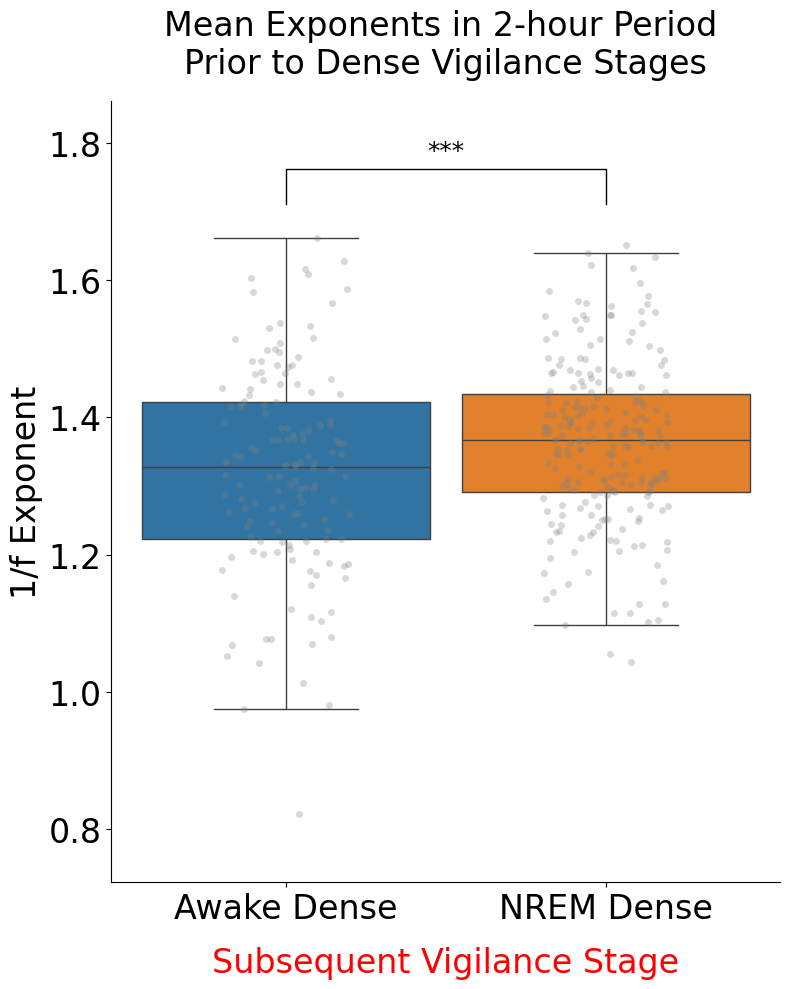

In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from pymer4.models import Lmer

def find_dense_periods(df, stage_value, window_size=3600):
    stage_binary = (df['sleepStage'] == stage_value).astype(int)
    stage_density = []
    
    for i in range(len(df) - window_size + 1):
        density = np.mean(stage_binary[i:i + window_size])
        stage_density.append(density)
    
    peaks, _ = find_peaks(stage_density, height=0.66, distance=1200)
    return [df['Timestamp'].iloc[peak] for peak in peaks]

def get_prior_mean_exponents(period_starts, exp_df):
    prior_means = []
    for start in period_starts:
        window_start = start - timedelta(hours=2)
        mask = (exp_df['Timestamp'] >= window_start) & (exp_df['Timestamp'] < start)
        prior_means.append(exp_df.loc[mask, 'exponent'].mean())
    return prior_means

def process_single_subject(csv_path, pickle_path):
    # Load data
    sleep_df = pd.read_csv(csv_path)
    sleep_df['Timestamp'] = pd.to_datetime(sleep_df['Timestamp'])
    
    with open(pickle_path, 'rb') as f:
        fg_models = pickle.load(f)
    
    # Calculate average exponents
    exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
    exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
    avg_exps = (exps_eeg1 + exps_eeg2) / 2
    
    exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0], 
                             periods=len(avg_exps), 
                             freq='10S')
    exp_df = pd.DataFrame({'Timestamp': exp_times, 'exponent': avg_exps})
    
    # Get dense periods
    nrem_periods = find_dense_periods(sleep_df, stage_value=2)
    awake_periods = find_dense_periods(sleep_df, stage_value=1)
    
    # Calculate prior exponents
    nrem_exps = get_prior_mean_exponents(nrem_periods, exp_df)
    awake_exps = get_prior_mean_exponents(awake_periods, exp_df)
    
    return nrem_exps, awake_exps

# File paths
csv_files = [
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_1Hz_stitched.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv'
]

pickle_files = [
    '/Volumes/harris/volkan/fooof/fooof_results/sub-007_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-010_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-011_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-015_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-016_ses-02_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl'
]

# Process all subjects
all_nrem_exps = []
all_awake_exps = []

for csv_file, pickle_file in zip(csv_files, pickle_files):
    nrem_exps, awake_exps = process_single_subject(csv_file, pickle_file)
    all_nrem_exps.extend(nrem_exps)
    all_awake_exps.extend(awake_exps)

def process_all_subjects(csv_files, pickle_files):
    data_list = []
    
    for subject_id, (csv_file, pickle_file) in enumerate(zip(csv_files, pickle_files), 1):
        nrem_exps, awake_exps = process_single_subject(csv_file, pickle_file)
        
        data_list.extend([{
            'Subject': f'sub-{subject_id:03d}',
            'Stage': 'NREM Dense',
            'Exponent': exp
        } for exp in nrem_exps])
        
        data_list.extend([{
            'Subject': f'sub-{subject_id:03d}',
            'Stage': 'Awake Dense',
            'Exponent': exp
        } for exp in awake_exps])
    
    return pd.DataFrame(data_list)

# Process data
df = process_all_subjects(csv_files, pickle_files)

# Run LME
model = Lmer("Exponent ~ Stage + (1|Subject)", data=df)
results = model.fit()

# Create plot with significance marker
plt.figure(figsize=(8, 10))

# Set category order
category_order = ['Awake Dense', 'NREM Dense']

# Calculate y-axis limits
y_min = df['Exponent'].min() - 0.1
y_max = df['Exponent'].max() + 0.2

# Create plot with specified order
sns.boxplot(data=df, x='Stage', y='Exponent', 
            order=category_order,
            showfliers=False,
            color='white',
            palette='tab10',
            width=0.9)

sns.stripplot(data=df, x='Stage', y='Exponent',
              order=category_order,
              color='grey', 
              alpha=0.3,
              size=5,
              jitter=0.2)

# Add significance marker
p_value = results.loc['StageNREM Dense', 'P-val']
x1, x2 = 0, 1
bar_height = y_max - 0.1

plt.plot([x1, x1, x2, x2], 
         [bar_height-0.05, bar_height, bar_height, bar_height-0.05], 
         color='black', linewidth=1)

# Add asterisks based on p-value
if p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    significance = '*'
else:
    significance = 'ns'

plt.text((x1+x2)/2, bar_height+0.01, significance, 
         ha='center', va='bottom', fontsize=18)

plt.ylim(y_min, y_max)
plt.title('Mean Exponents in 2-hour Period \nPrior to Dense Vigilance Stages', pad=20, fontsize=24)
plt.xlabel('Subsequent Vigilance Stage', color='red', fontsize=24, labelpad=15)
plt.ylabel('1/f Exponent', fontsize=24)
plt.tick_params(labelsize=24)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_4016/2701042670.py:42: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_4016/2701042670.py:42: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_4016/2701042670.py:42: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_4016/2701042670.py:42: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/1pj7

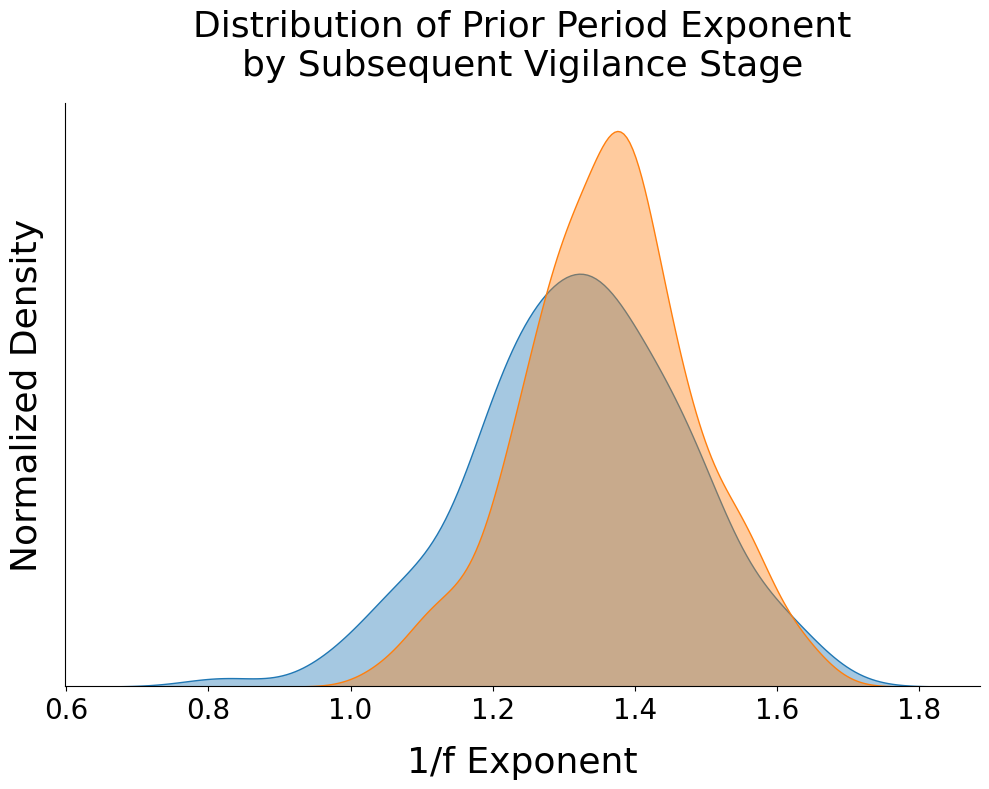

In [8]:
import pandas as pd
import numpy as np
import pickle
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from pymer4.models import Lmer

def find_dense_periods(df, stage_value, window_size=3600):
    stage_binary = (df['sleepStage'] == stage_value).astype(int)
    stage_density = []
    
    for i in range(len(df) - window_size + 1):
        density = np.mean(stage_binary[i:i + window_size])
        stage_density.append(density)
    
    peaks, _ = find_peaks(stage_density, height=0.66, distance=1200)
    return [df['Timestamp'].iloc[peak] for peak in peaks]

def get_prior_mean_exponents(period_starts, exp_df):
    prior_means = []
    for start in period_starts:
        window_start = start - timedelta(hours=2)
        mask = (exp_df['Timestamp'] >= window_start) & (exp_df['Timestamp'] < start)
        prior_means.append(exp_df.loc[mask, 'exponent'].mean())
    return prior_means

def process_single_subject(csv_path, pickle_path):
    # Load data
    sleep_df = pd.read_csv(csv_path)
    sleep_df['Timestamp'] = pd.to_datetime(sleep_df['Timestamp'])
    
    with open(pickle_path, 'rb') as f:
        fg_models = pickle.load(f)
    
    # Calculate average exponents
    exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
    exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
    avg_exps = (exps_eeg1 + exps_eeg2) / 2
    
    exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0], 
                             periods=len(avg_exps), 
                             freq='10S')
    exp_df = pd.DataFrame({'Timestamp': exp_times, 'exponent': avg_exps})
    
    # Get dense periods
    nrem_periods = find_dense_periods(sleep_df, stage_value=2)
    awake_periods = find_dense_periods(sleep_df, stage_value=1)
    
    # Calculate prior exponents
    nrem_exps = get_prior_mean_exponents(nrem_periods, exp_df)
    awake_exps = get_prior_mean_exponents(awake_periods, exp_df)
    
    return nrem_exps, awake_exps

# File paths
csv_files = [
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_1Hz_stitched.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv'
]

pickle_files = [
    '/Volumes/harris/volkan/fooof/fooof_results/sub-007_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-010_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-011_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-015_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-016_ses-02_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl'
]


def process_all_subjects(csv_files, pickle_files):
    data_list = []
    
    for subject_id, (csv_file, pickle_file) in enumerate(zip(csv_files, pickle_files), 1):
        nrem_exps, awake_exps = process_single_subject(csv_file, pickle_file)
        
        data_list.extend([{
            'Subject': f'sub-{subject_id:03d}',
            'Stage': 'NREM Dense',
            'Exponent': exp
        } for exp in nrem_exps])
        
        data_list.extend([{
            'Subject': f'sub-{subject_id:03d}',
            'Stage': 'Awake Dense',
            'Exponent': exp
        } for exp in awake_exps])
    
    return pd.DataFrame(data_list)

# Process data
df = process_all_subjects(csv_files, pickle_files)

plt.figure(figsize=(10, 8))

# Define colors for each stage
colors = {'Awake Dense': '#1f77b4', 'NREM Dense': '#ff7f0e'}

# Create KDE plot for each stage
for stage in ['Awake Dense', 'NREM Dense']:
    stage_data = df[df['Stage'] == stage]['Exponent']
    sns.kdeplot(data=stage_data, 
                label=stage,
                color=colors[stage],
                fill=True,
                alpha=0.4)

plt.title('Distribution of Prior Period Exponent\nby Subsequent Vigilance Stage', 
          pad=20, 
          fontsize=26)
plt.xlabel('1/f Exponent', 
          fontsize=26, 
          labelpad=15)
plt.ylabel('Normalized Density', 
          fontsize=26, labelpad=15)

# Customize the plot
plt.tick_params(labelsize=20)
plt.yticks([])

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()